In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag, pos_tag_sents
from collections import Counter
from scipy.spatial.distance import pdist,squareform
import numpy as np

%matplotlib inline

In [2]:
path = 'E:/unist/2-1/'
data = pd.read_csv(path+'abstract.csv', encoding='cp949')
data.head()

,title,contents
0,Beyond word importance: using contextual decom...,The driving force behind the recent success of...
1,Generating Wikipedia by Summarizing Long Seque...,We show that generating English Wikipedia arti...
2,MaskGAN: Better Text Generation via Filling in...,Recurrent neural networks (RNNs) are a common ...
3,Natural TTS Synthesis By Conditioning WaveNet ...,"This paper describes Tacotron 2, a neural netw..."
4,SHAPED: Shared-Private Encoder-Decoder for Tex...,Supervised training of abstractive language ge...


In [3]:
# Normalization
l1 = ['\(CD\)', 'CD', '\(MOS\)', '\(RNNs\)', 'LSTM', 'Yelp', 'SST', 'WaveNet', 'Q\-function', 'GAN', 'RNN', 'Tacotron\ 2', 'F0', 'FST', 'PRM\-RL', 'PRMs',\
      'PRM', 'RL', '\-\ ', '\-', 'TTS', 'MOS']
l2 = ['', 'contenxtual decomposition', '', '', 'long short term memory', 'corporation', 'project', 'generative neural network',\
     'distribution', 'generative adversarial network', 'recurrent neural network', 'neural network model', 'accent',\
     'finite state transducer', 'probabilistic road map reinforcement learning', 'probabilistic road map','probabilistic road map', \
      'reinforcement learning', '', ' ', 'text to speach', 'mean opinion score']

for a, b in zip(l1, l2):
    data['contents'] = data['contents'].str.replace(a, ' '+b)
    data['title'] = data['title'].str.replace(a, ' '+b)

In [4]:
data['contents'].iloc[2]

'Recurrent neural networks   are a common method of generating text token by token. These models are typically trained via maximum likelihood (known in this context as teacher forcing). However, this approach frequently suffers from problems when using a trained model to generate new text since when generating words later in the sequence the model often conditions on a sequence of words that was never observed at training time. We explore methods for using Generative Adversarial Networks ( generative adversarial networks) as an alternative to teacher forcing to generate discrete sequences. In particular, we consider a conditional  generative adversarial network that fills in missing text conditioned on the surrounding context. We show qualitatively and quantitatively evidence that this produces more realistic text samples compared to a maximum likelihood trained model. We also propose a new task that quantitatively measures the quality of  recurrent neural network produced samples.'

In [5]:
# Tokenize
doc = pd.DataFrame()
doc['id'] = data.index
doc['title'] = data['title'].str.strip().str.split('[\W_]+')
doc['contents'] = data['contents'].str.strip().str.split('[\W_]+')
doc.head()

,id,title,contents
0,0,"[Beyond, word, importance, using, contextual, ...","[The, driving, force, behind, the, recent, suc..."
1,1,"[Generating, Wikipedia, by, Summarizing, Long,...","[We, show, that, generating, English, Wikipedi..."
2,2,"[Mask, generative, adversarial, network, Bette...","[Recurrent, neural, networks, are, a, common, ..."
3,3,"[Natural, text, to, speach, Synthesis, By, Con...","[This, paper, describes, neural, network, mode..."
4,4,"[SHAPED, Shared, Private, Encoder, Decoder, fo...","[Supervised, training, of, abstractive, langua..."


In [6]:
# Tokenize
doc['title'] = doc['title'].apply(lambda x: [a for a in x if a!=''])
doc['contents'] = doc['contents'].apply(lambda x: [a for a in x if a!=''])
doc.head()

,id,title,contents
0,0,"[Beyond, word, importance, using, contextual, ...","[The, driving, force, behind, the, recent, suc..."
1,1,"[Generating, Wikipedia, by, Summarizing, Long,...","[We, show, that, generating, English, Wikipedi..."
2,2,"[Mask, generative, adversarial, network, Bette...","[Recurrent, neural, networks, are, a, common, ..."
3,3,"[Natural, text, to, speach, Synthesis, By, Con...","[This, paper, describes, neural, network, mode..."
4,4,"[SHAPED, Shared, Private, Encoder, Decoder, fo...","[Supervised, training, of, abstractive, langua..."


In [7]:
# Normalization ( to lowercase )
doc['title'] = doc['title'].apply(lambda x: [a.lower() for a in x])
doc['contents'] = doc['contents'].apply(lambda x: [a.lower() for a in x])
doc.head()

,id,title,contents
0,0,"[beyond, word, importance, using, contextual, ...","[the, driving, force, behind, the, recent, suc..."
1,1,"[generating, wikipedia, by, summarizing, long,...","[we, show, that, generating, english, wikipedi..."
2,2,"[mask, generative, adversarial, network, bette...","[recurrent, neural, networks, are, a, common, ..."
3,3,"[natural, text, to, speach, synthesis, by, con...","[this, paper, describes, neural, network, mode..."
4,4,"[shaped, shared, private, encoder, decoder, fo...","[supervised, training, of, abstractive, langua..."


In [8]:
# Pos Tagging
doc['title'] = doc['title'].apply(lambda x: pos_tag(x))
doc['contents'] = doc['contents'].apply(lambda x: pos_tag(x))
doc.head()

,id,title,contents
0,0,"[(beyond, IN), (word, NN), (importance, NN), (...","[(the, DT), (driving, NN), (force, NN), (behin..."
1,1,"[(generating, VBG), (wikipedia, NN), (by, IN),...","[(we, PRP), (show, VBP), (that, IN), (generati..."
2,2,"[(mask, NN), (generative, JJ), (adversarial, J...","[(recurrent, JJ), (neural, JJ), (networks, NNS..."
3,3,"[(natural, JJ), (text, NN), (to, TO), (speach,...","[(this, DT), (paper, NN), (describes, VBZ), (n..."
4,4,"[(shaped, VBN), (shared, JJ), (private, JJ), (...","[(supervised, JJ), (training, NN), (of, IN), (..."


In [9]:
# Stemming
st = PorterStemmer()
doc['title'] = doc['title'].apply(lambda x: [(st.stem(a[0]), a[1]) for a in x])
doc['contents'] = doc['contents'].apply(lambda x: [(st.stem(a[0]), a[1]) for a in x])
doc.head()

,id,title,contents
0,0,"[(beyond, IN), (word, NN), (import, NN), (use,...","[(the, DT), (drive, NN), (forc, NN), (behind, ..."
1,1,"[(gener, VBG), (wikipedia, NN), (by, IN), (sum...","[(we, PRP), (show, VBP), (that, IN), (gener, V..."
2,2,"[(mask, NN), (gener, JJ), (adversari, JJ), (ne...","[(recurr, JJ), (neural, JJ), (network, NNS), (..."
3,3,"[(natur, JJ), (text, NN), (to, TO), (speach, V...","[(thi, DT), (paper, NN), (describ, VBZ), (neur..."
4,4,"[(shape, VBN), (share, JJ), (privat, JJ), (enc...","[(supervis, JJ), (train, NN), (of, IN), (abstr..."


In [10]:
# Stopword 
stops = ['DT', 'CC', 'TO', 'WDT', 'RB', 'PRP$', 'IN', 'VBP', 'VBZ', 'PRP', 'CD']
doc['title'] = doc['title'].apply(lambda x: [a[0] for a in x if a[1] not in stops])
doc['contents'] = doc['contents'].apply(lambda x: [a[0] for a in x if a[1] not in stops])
doc['all'] = doc['title']+doc['contents']
doc.head()

,id,title,contents,all
0,0,"[word, import, use, contextu, decomposit, extr...","[drive, forc, recent, success, long, short, te...","[word, import, use, contextu, decomposit, extr..."
1,1,"[gener, wikipedia, summar, long, sequenc]","[gener, english, wikipedia, articl, can, be, a...","[gener, wikipedia, summar, long, sequenc, gene..."
2,2,"[mask, gener, adversari, network, better, text...","[recurr, neural, network, common, method, gene...","[mask, gener, adversari, network, better, text..."
3,3,"[natur, text, speach, synthesi, condit, gener,...","[paper, neural, network, model, neural, networ...","[natur, text, speach, synthesi, condit, gener,..."
4,4,"[shape, share, privat, encod, decod, text, sty...","[supervis, train, abstract, languag, gener, mo...","[shape, share, privat, encod, decod, text, sty..."


In [11]:
# ID별 단어 리스트(contents)
rows = list()
for row in doc[['id', 'contents']].iterrows():
    r = row[1]
    for word in r['contents']:
        rows.append((r.id, word))

content_words = pd.DataFrame(rows, columns=['id', 'word'])
content_words.head()

,id,word
0,0,drive
1,0,forc
2,0,recent
3,0,success
4,0,long


In [12]:
# ID별 단어 리스트(title)
rows = list()
for row in doc[['id', 'title']].iterrows():
    r = row[1]
    for word in r['title']:
        rows.append((r.id, word))

title_words = pd.DataFrame(rows, columns=['id', 'word'])
title_words.head()

,id,word
0,0,word
1,0,import
2,0,use
3,0,contextu
4,0,decomposit


In [13]:
# ID별 단어 리스트(all)
rows = list()
for row in doc[['id', 'all']].iterrows():
    r = row[1]
    for word in r['all']:
        rows.append((r.id, word))

all_words = pd.DataFrame(rows, columns=['id', 'word'])
all_words.head()

,id,word
0,0,word
1,0,import
2,0,use
3,0,contextu
4,0,decomposit


In [14]:
# Content word count
content_counts = content_words.groupby('id')\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})
content_counts.head()

n_w
id word           
0  term          5
   decomposit    4
   long          4
   memori        4
   short         4

In [15]:
# Title word count
title_counts = title_words.groupby('id')\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})
title_counts.head()

n_w
id word           
0  contextu      1
   decomposit    1
   extract       1
   import        1
   interact      1

In [16]:
# All word count
all_counts = all_words.groupby('id')\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'n_w'})
all_counts.head()

n_w
id word           
0  term          6
   decomposit    5
   long          5
   memori        5
   short         5

In [17]:
# All word count
x = all_words\
    .word.value_counts()\
    .to_frame()\
    .rename(columns={'word':'count'})
x.reset_index(inplace=True)
x.head()

,index,count
0,learn,41
1,robot,28
2,gener,25
3,model,24
4,reinforc,20


In [18]:
x['count'].describe()

count    388.000000
mean       2.605670
std        3.832631
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       41.000000
Name: count, dtype: float64

In [19]:
x.to_csv(path+'word_count.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'E:/unist/2-1/word_count.csv'

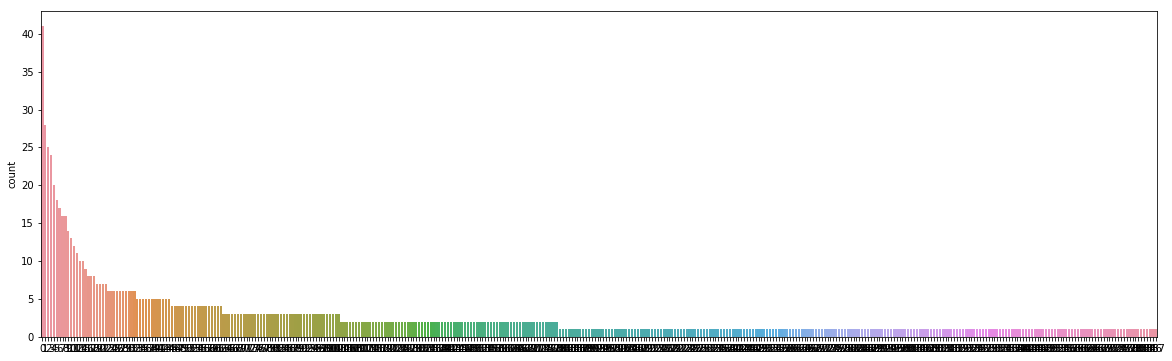

In [20]:
import seaborn as sns
plt.figure(figsize=(20,6))
sns.barplot(x.index, x['count'])

In [21]:
word_sum = all_counts.groupby(level=0).sum().rename(columns={'n_w': 'n_d'})
word_sum.head()

,n_d
id,
0,99
1,66
2,86
3,88
4,104


In [22]:
# BM 25
c_tf = content_counts.copy()
k=5
c_tf['tf'] = (k+1)*c_tf.n_w/(c_tf.n_w+k)
c_tf.head()

n_w        tf
id word                     
0  term          5  3.000000
   decomposit    4  2.666667
   long          4  2.666667
   memori        4  2.666667
   short         4  2.666667

In [23]:
c_tf['tf'].describe()

count    573.000000
mean       1.342674
std        0.621341
min        1.000000
25%        1.000000
50%        1.000000
75%        1.714286
max        4.000000
Name: tf, dtype: float64

In [24]:
title_counts['n_w'].value_counts()

1    82
2     3
Name: n_w, dtype: int64

In [25]:
t_tf = title_counts.copy()
t_tf.columns = ['tf']
t_tf.head()

tf
id word          
0  contextu     1
   decomposit   1
   extract      1
   import       1
   interact     1

In [26]:
c_tf.reset_index(inplace=True)
t_tf.reset_index(inplace=True)

In [27]:
c_tf.head()

,id,word,n_w,tf
0,0,term,5,3.000000
1,0,decomposit,4,2.666667
2,0,long,4,2.666667
3,0,memori,4,2.666667
4,0,short,4,2.666667


In [28]:
tf = pd.merge(t_tf, c_tf, on=['word', 'id'], how='outer').drop('n_w', axis=1).fillna(0)
tf['tf'] = tf['tf_x']*0.8 + tf['tf_y']*0.2
tf.head()

,id,word,tf_x,tf_y,tf
0,0,contextu,1.0,1.000000,1.000000
1,0,decomposit,1.0,2.666667,1.333333
2,0,extract,1.0,1.000000,1.000000
3,0,import,1.0,0.000000,0.800000
4,0,interact,1.0,0.000000,0.800000


In [29]:
c_d = all_words.id.nunique()
idf = all_words.groupby('word')\
    .id\
    .nunique()\
    .to_frame()\
    .rename(columns={'id':'i_d'})\
    .sort_values('i_d')
idf['idf'] = np.log(c_d/idf.i_d.values)
idf.reset_index(inplace=True)
idf.head()

,word,i_d,idf
0,abil,1,2.302585
1,paradigm,1,2.302585
2,own,1,2.302585
3,overcom,1,2.302585
4,overal,1,2.302585


In [30]:
tfidf = pd.merge(tf, idf, on=['word'], how='outer').drop(['i_d', 'tf_x', 'tf_y'], axis=1).fillna(0)
tfidf['tfidf'] = tfidf['tf'] * tfidf['idf']
tfidf.head()

,id,word,tf,idf,tfidf
0,0,contextu,1.000000,2.302585,2.302585
1,0,decomposit,1.333333,2.302585,3.070113
2,0,extract,1.000000,1.609438,1.609438
3,1,extract,0.342857,1.609438,0.551807
4,0,import,0.800000,2.302585,1.842068


In [31]:
tfidf = tfidf[tfidf['tf']>1]

In [32]:
tfidf = tfidf.pivot('id', 'word', 'tfidf').fillna(0)
tfidf

word,adversari,asynchron,base,collect,decomposit,deep,distribut,gener,learn,long,...,short,spectrogram,style,summar,supervis,task,term,text,wikipedia,word
id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,3.070113,0.000000,0.000000,0.000000,0.000000,1.605297,...,2.145917,0.000000,0.000000,0.000000,0.000000,0.000000,3.223619,0.000000,0.000000,1.839358
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.638532,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.631526,0.000000,0.000000,0.000000,0.000000,2.631526,0.000000
2,2.011797,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.151680,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.605297,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.638532,0.000000,0.000000,...,0.000000,2.878231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.542439,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.970406,0.000000,0.000000,0.000000,0.000000,0.000000,0.856020,1.504966,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.518800,0.000000,0.000000,0.000000,0.000000
6,0.000000,1.839358,0.000000,2.631526,0.000000,0.000000,1.375969,0.000000,0.499345,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,2.253213,0.000000,0.000000,0.560489,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
euclid = squareform(pdist(tfidf, metric='euclidean'))
cosine = squareform(pdist(tfidf, metric='cosine'))
manh = squareform(pdist(tfidf, metric='cityblock'))
jaccard = squareform(pdist(tfidf, metric='euclidean'))

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cosine2 = scaler.fit_transform(cosine)

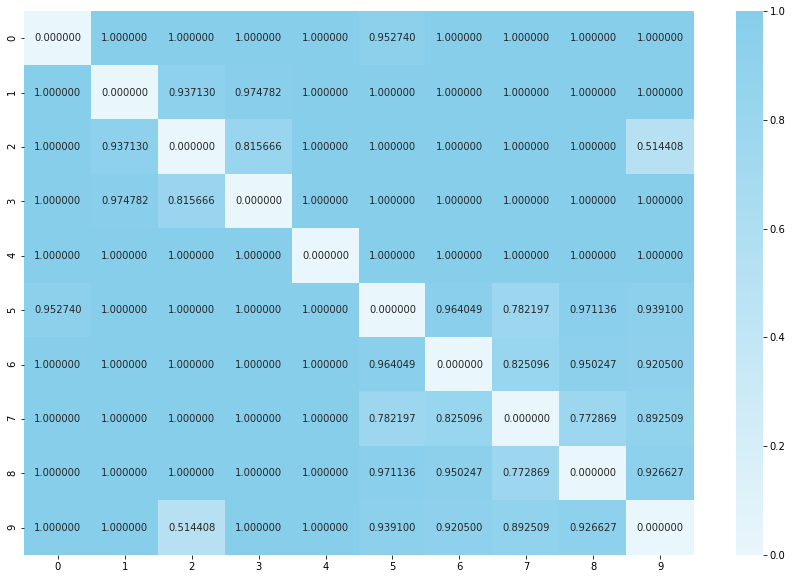

In [35]:
plt.figure(figsize=(15, 10))
sns.heatmap(cosine, cmap=sns.light_palette("skyblue", as_cmap=True), annot=True, fmt="f")

plt.show()

In [36]:
cosine[cosine>0].min()

0.51440793369438187

In [22]:
tn = RegexpTokenizer("[\w]+")
st = PorterStemmer()
lm = WordNetLemmatizer()

tokens = []
for content in data.contents:
    
    # Tokenization
    token = tn.tokenize(content)
    
    # Normalization
    token_norm = [t.lower() for t in token]
    token_pos = pos_tag(token_norm)
    
    # Stemmization
    token_stem = [(st.stem(t[0]), t[1]) for t in token_pos]
    #token_lemm = [lm.lemmatize(t) for t in token_stem]

    
    # Remove Stopwords
    stops = ['DT', 'CC', 'TO', 'WDT', 'RB', 'PRP$', 'IN', 'VBP', 'VBZ', 'PRP', 'CD']
    words = [word for word, pos in token_stem if pos not in stops]


    tokens.append(words)
    
print(tokens[0])

['drive', 'forc', 'recent', 'success', 'lstm', 'been', 'abil', 'learn', 'complex', 'non', 'linear', 'relationship', 'inabl', 'de', 'scribe', 'relationship', 'led', 'lstm', 'be', 'character', 'black', 'box', 'end', 'contextu', 'decomposit', 'cd', 'novel', 'algorithm', 'captur', 'contribut', 'combin', 'word', 'variabl', 'term', 'cd', 'score', 'task', 'sentiment', 'analysi', 'yelp', 'sst', 'data', 'set', 'cd', 'abl', 'reliabl', 'identifi', 'word', 'phrase', 'contrast', 'senti', 'ment', 'how', 'combin', 'yield', 'lstm', 's', 'final', 'predict', 'use', 'phrase', 'level', 'label', 'sst', 'cd', 'abl', 'extract', 'posit', 'neg', 'negat', 'lstm', 'someth', 'been', 'done']


In [56]:
words = [t for token in tokens for t in token]
counts = Counter(words)
counts

Counter({'abil': 1,
         'abl': 3,
         'ablat': 1,
         'abstract': 3,
         'accord': 1,
         'accur': 1,
         'achiev': 2,
         'acoust': 1,
         'act': 1,
         'action': 2,
         'adapt': 1,
         'advantag': 1,
         'adversari': 9,
         'aerial': 2,
         'agent': 6,
         'algorithm': 4,
         'allow': 1,
         'altern': 2,
         'analysi': 1,
         'appar': 1,
         'applic': 3,
         'approach': 2,
         'approxim': 1,
         'architectur': 6,
         'articl': 3,
         'asynchron': 2,
         'attend': 1,
         'autonom': 1,
         'autonomi': 1,
         'averag': 1,
         'averagestyl': 1,
         'baselin': 1,
         'be': 6,
         'behavior': 1,
         'best': 2,
         'better': 3,
         'black': 1,
         'box': 1,
         'can': 10,
         'cannot': 1,
         'capabl': 2,
         'captur': 3,
         'cargo': 2,
         'case': 1,
         'cd': 4,
         

In [ ]:
counts = Counter(nounlist)

In [46]:
data['contents'].iloc[0]

'The driving force behind the recent success of LSTMs has been their ability to learn complex and non-linear relationships. Consequently, our inability to de- scribe these relationships has led to LSTMs being characterized as black boxes. To this end, we introduce contextual decomposition (CD), a novel algorithm for capturing the contributions of combinations of words or variables in terms of CD scores. On the task of sentiment analysis with the Yelp and SST data sets, we show that CD is able to reliably identify words and phrases of contrasting senti- ment, and how they are combined to yield the LSTM’s final prediction. Using the phrase-level labels in SST, we also demonstrate that CD is able to successfully extract positive and negative negations from an LSTM, something which has not previously been done.'

In [39]:
print(token_pos)

[('there', 'EX'), ('has', 'VBZ'), ('been', 'VBN'), ('a', 'DT'), ('recent', 'JJ'), ('paradigm', 'NN'), ('shift', 'NN'), ('in', 'IN'), ('robotics', 'NNS'), ('to', 'TO'), ('data', 'VB'), ('driven', 'NNS'), ('learning', 'VBG'), ('for', 'IN'), ('planning', 'NN'), ('and', 'CC'), ('control', 'NN'), ('due', 'JJ'), ('to', 'TO'), ('large', 'JJ'), ('number', 'NN'), ('of', 'IN'), ('experiences', 'NNS'), ('required', 'VBN'), ('for', 'IN'), ('training', 'VBG'), ('most', 'JJS'), ('of', 'IN'), ('these', 'DT'), ('approaches', 'NNS'), ('use', 'VBP'), ('a', 'DT'), ('self', 'NN'), ('supervised', 'VBN'), ('paradigm', 'NN'), ('using', 'VBG'), ('sensors', 'NNS'), ('to', 'TO'), ('measure', 'VB'), ('success', 'NN'), ('failure', 'NN'), ('however', 'RB'), ('in', 'IN'), ('most', 'JJS'), ('cases', 'NNS'), ('these', 'DT'), ('sensors', 'NNS'), ('provide', 'VBP'), ('weak', 'JJ'), ('supervision', 'NN'), ('at', 'IN'), ('best', 'JJS'), ('in', 'IN'), ('this', 'DT'), ('work', 'NN'), ('we', 'PRP'), ('propose', 'VBP'), ('an

In [92]:
lm.lemmatize('is', )

'is'

In [ ]:
['DT', 'CC', 'TO', 'VBN', 'WDT', 'RB', 'PRP$', 'IN', 'VBP', 'VBZ', 'PRP']

1. 같은 pos tagging은 stemming 하기 전에
2. lemmatization에 품사 넣어줘야함 -> 안쓰는게 좋을 듯
3. 품사를 굉장히 세세하게 나누는 경향 (ex. is : VBZ, been : VBN)

In [83]:
vocab = [t for token in tokens for t in token]
nouns = [word for word, pos in vocab if pos == 'JJ']
print(set(nouns))

ValueError: too many values to unpack (expected 2)

In [84]:
vocab

['drive',
 'forc',
 'recent',
 'success',
 'lstm',
 'abil',
 'learn',
 'complex',
 'nonlinear',
 'relationship',
 'inabl',
 'describ',
 'relationship',
 'lstm',
 'be',
 'black',
 'box',
 'end',
 'contextu',
 'decomposit',
 'cd',
 'novel',
 'algorithm',
 'captur',
 'contribut',
 'combin',
 'word',
 'variabl',
 'term',
 'cd',
 'score',
 'task',
 'sentiment',
 'analysi',
 'yelp',
 'sst',
 'data',
 'set',
 'cd',
 'abl',
 'reliabl',
 'identifi',
 'word',
 'phrase',
 'contrast',
 'sentiment',
 'how',
 'yield',
 'lstm',
 's',
 'final',
 'predict',
 'use',
 'phraselevel',
 'label',
 'sst',
 'cd',
 'abl',
 'extract',
 'posit',
 'neg',
 'negat',
 'lstm',
 'someth',
 'gener',
 'english',
 'wikipedia',
 'articl',
 'can',
 'be',
 'multidocu',
 'summar',
 'sourc',
 'document',
 'extract',
 'summar',
 'identifi',
 'salient',
 'inform',
 'neural',
 'abstract',
 'model',
 'gener',
 'articl',
 'abstract',
 'model',
 'decoderonli',
 'architectur',
 'can',
 'attend',
 'longer',
 'typic',
 'encoderdecod',


In [86]:
for v in vocab:
    print(v)

[('the', 'DT'), ('drive', 'NN'), ('forc', 'NN'), ('behind', 'IN'), ('the', 'DT'), ('recent', 'JJ'), ('success', 'NN'), ('of', 'IN'), ('lstm', 'JJ'), ('ha', 'NNS'), ('been', 'VBN'), ('their', 'PRP$'), ('abil', 'NN'), ('to', 'TO'), ('learn', 'VB'), ('complex', 'JJ'), ('and', 'CC'), ('non', 'JJ'), ('linear', 'JJ'), ('relationship', 'NN'), ('consequ', 'VBZ'), ('our', 'PRP$'), ('inabl', 'NN'), ('to', 'TO'), ('de', 'VB'), ('scribe', 'FW'), ('these', 'DT'), ('relationship', 'NN'), ('ha', 'NN'), ('led', 'VBD'), ('to', 'TO'), ('lstm', 'VB'), ('be', 'VB'), ('character', 'JJR'), ('a', 'DT'), ('black', 'JJ'), ('box', 'NN'), ('to', 'TO'), ('thi', 'VB'), ('end', 'NN'), ('we', 'PRP'), ('introduc', 'VBP'), ('contextu', 'JJ'), ('decomposit', 'NN'), ('cd', 'NN'), ('a', 'DT'), ('novel', 'JJ'), ('algorithm', 'NN'), ('for', 'IN'), ('captur', 'NN'), ('the', 'DT'), ('contribut', 'NN'), ('of', 'IN'), ('combin', 'NN'), ('of', 'IN'), ('word', 'NN'), ('or', 'CC'), ('variabl', 'NN'), ('in', 'IN'), ('term', 'NN'),

In [47]:
t = [t for token in tokens for t in token]
text = nltk.Text(t)

In [70]:
temp.values

<function FreqDist.values>

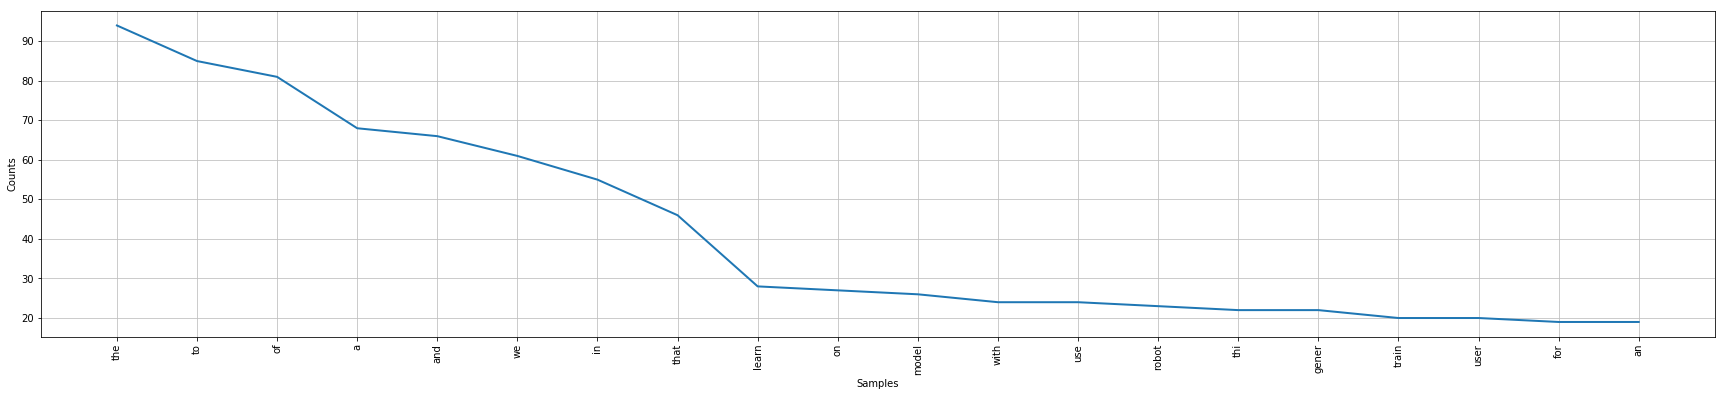

In [59]:
plt.figure(figsize=(30,6))
text.plot(20)